# Copyright Netherlands eScience Center <br>
** Function     : Clustering the patterns of climate fields from reanalyses ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.12.17 ** <br>
** Last Update  : 2019.01.09 ** <br>
Description     : The script aims to implement machine learning to cluster the different patterns given by the variable fields from reanalyses. Some fields are organized as patterns by the climate system (such as SLP, z500). Point-wise analysis then is not as powerful as the clustering methods so as to decrypt the data. Here we will use K-mean clustering to work on the SLP fields in the polar circle.<br>

Return Values   : png <br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib <br>
variables       : SLP <br>
Caveat          : Due to the nature of clustering methods used here, we have to do multiple tests to make sure that the results we obtained are not due to the "unlucky" initialization.<br>

In [1]:
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from scipy import stats
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# constants
constant = {'g' : 9.80616,          # gravititional acceleration [m / s2]
            'R' : 6371009,          # radius of the earth [m]
            'cp': 1004.64,          # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,          # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,        # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,        # gas constant for water vapour [J/(kg*K)]
            'omega' : 7.2921*1E-5,  # Roration rate of the earth [rad/s]
            'rho_air' : 1.225,      # Surface air density [kg/m3]
            'Cd' : 1.56,            # Drag coefficient of 10m wind at 15 Celsius - from Stuart Smith 1988
            }

print ('****************************************************************************')
print ('********************    latitude index of insteret     *********************')
print ('****************************************************************************')
# 60N
lat_ERAI_60 = 40

****************************************************************************
********************    latitude index of insteret     *********************
****************************************************************************


In [3]:
################################ data retriever  ######################################
def var_key_retrieve(datapath, year, month):
    # get the path to each datasets
    #print ("Start retrieving datasets {} (y) {} (m)".format(year,month))
    # The shape of each variable is (121,480)
    datapath = os.path.join(datapath_daily, 'era{}'.format(year),
                            'pressure_daily_075_diagnostic_{}_{}_slp.nc'.format(year,month))
    # get the variable keys
    var_key = Dataset(datapath)

    #print ("Retrieving datasets successfully and return the variable key!")
    return var_key

def retriver(key):
    #print ('Extract subdaily fields and calculate the variance for each month.')
    slp_subdaily = var_key.variables['msl'][:] # mean sea level pressure
    t, y, x = slp_subdaily.shape
    tt = t//4
    if tt == 29:
        slp_daily = np.zeros((tt-1, lat_ERAI_60+1, x), dtype=float)
        for i in np.arange(tt-1):
            slp_daily[i,:,:] = np.mean(slp_subdaily[i:i+4,:lat_ERAI_60+1,:],0)        
    else:
        slp_daily = np.zeros((tt, lat_ERAI_60+1, x), dtype=float)
        for i in np.arange(tt):
            slp_daily[i,:,:] = np.mean(slp_subdaily[i:i+4,:lat_ERAI_60+1,:],0)
    
    return slp_daily

In [4]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    # ERAI 3D fields on pressure level
    datapath_daily = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression/surface/slp'
    # AMET
    datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
    # fields
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision/patterns/Synoptic'
    #####################################################################################
    print ('*********************** extract variables *************************')
    # AMET
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI, 
                                             'model_daily_075_1979_2016_E_zonal_int.nc'))
    # fields
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    # from 20N - 90N
    # ! attention MERRA2 goes from lower lat to higher lat
    AMET_ERAI = dataset_ERAI_AMET.variables['E'][:,:,lat_ERAI_60]/1000 # from Tera Watt to Peta Watt 
    # 3D fields [time, lat, lon] from 20N - 90N
    #SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:,:95,:] #Pa
    #SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:95,:]
    # others
    year_ERAI = dataset_ERAI_AMET.variables['year'][:]             # from 1979 to 2016
    latitude_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    #latitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:95]
    #longitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]

*********************** extract variables *************************


In [5]:
    ####################################################################
    ######  Create time namelist matrix for variable extraction  #######
    ####################################################################
    start_year = 1979
    end_year = 2016
    # date and time arrangement
    # namelist of month and days for file manipulation
    #namelist_month = ['1','2','3','4','5','6','7','8','9','10','11','12']
    lengthlist_day = np.array(([31,28,31,30,31,30,31,31,30,31,30,31]), dtype=int)
    # index of months
    period = np.arange(start_year,end_year+1,1)
    index_month = np.arange(1,13,1)
    ####################################################################
    ######       Extract invariant and calculate constants       #######
    ####################################################################
    # get invariant from benchmark file
    Dim_year = len(period)
    Dim_month = len(index_month)
    Dim_latitude = len(latitude_ERAI[:lat_ERAI_60+1]) # from 0N onwards
    Dim_longitude = 480
    #############################################
    #####   Create space for stroing data   #####
    #############################################
    # data pool
    pool_slp = np.zeros((365*Dim_year,Dim_latitude,Dim_longitude),dtype = float)
    latitude = np.zeros(Dim_latitude,dtype=float)
    longitude = np.zeros(Dim_longitude,dtype=float)
    # loop for calculation
    for i in period:
        for j in index_month:
        # get the key of each variable
            var_key = var_key_retrieve(datapath_daily,i, j)
            latitude = var_key.variables['latitude'][:lat_ERAI_60+1]
            longitude = var_key.variables['longitude'][:]
            slp = retriver(var_key)
            if j == 1:
                pool_slp[365*(i-1979):365*(i-1979)+lengthlist_day[j-1],:,:] = slp
            else:
                num_days = np.sum(lengthlist_day[0:j-1])
                pool_slp[365*(i-1979)+num_days:365*(i-1979)+num_days+lengthlist_day[j-1],:,:] = slp

Start retrieving datasets 1979 (y) 1 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the variance for each month.
Start retrieving datasets 1979 (y) 2 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the variance for each month.
Start retrieving datasets 1979 (y) 3 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the variance for each month.
Start retrieving datasets 1979 (y) 4 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the variance for each month.
Start retrieving datasets 1979 (y) 5 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the variance for each month.
Start retrieving datasets 1979 (y) 6 (m)
Retrieving datasets successfully and return the variable key!
Extract subdaily fields and calculate the varia

In [6]:
    print (pool_slp.shape)

(13870, 41, 480)


In [7]:
    print ('======================   data allocation   ======================')
    # we get the assembled series
    SLP_ERAI = pool_slp
    # we need to get the time series of SLP for the clustering
    # reshape the input time series
    # we apply the Fortran like index ordering
    t_era, y_era, x_era = SLP_ERAI.shape
    SLP_ERAI_series_2D = np.reshape(SLP_ERAI,[t_era, y_era*x_era], order='F')

======================   data allocation   ======================


In [8]:
    %%time
    print ('======================   K-mean clustering   ======================')
    ############ full set-up of K-mean ############
    # see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    #class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10,
    #                             max_iter=300, tol=0.0001, precompute_distances=’auto’,
    #                             verbose=0, random_state=None, copy_x=True, n_jobs=None,
    #                             algorithm=’auto’)
    # n_init : int, default: 10
    # Number of time the k-means algorithm will be run with different centroid seeds.
    # The final results will be the best output of n_init consecutive runs in terms of inertia.
    ###############################################
    kmeans = KMeans(n_clusters=4)
    model = kmeans.fit(SLP_ERAI_series_2D)
    clust_labels = model.predict(SLP_ERAI_series_2D)
    print("ERA-Interim\n", model)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
CPU times: user 5min 23s, sys: 30.2 s, total: 5min 53s
Wall time: 4min 22s


In [9]:
    centers = model.cluster_centers_
    n_era, nn_era = centers.shape
    # shape back to the spatial arrangement
    centers_spatial = np.reshape(centers,[n_era, y_era, x_era], order='F')

======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


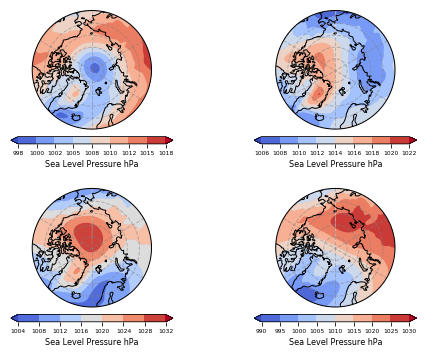

In [10]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_daily_Kmean.png'), dpi=300)
    plt.close(fig)

In [ ]:
    print ('======================   check the heat map of K-mean   ======================')
    print (clust_labels)
    print (len(clust_labels[clust_labels==3]))

The benchmark of the implementation of K-mean is listed above. Now we will apply this method to the seasonal anomalies of SLP from each reanalyses.<br>

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [11]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [12]:
    print ('================   K-mean clustering of SLP anomalies in winter  ================')
    # get winter time series
    # DJF (31+28+31)
    SLP_ERAI_daily_DJF = np.zeros((90*Dim_year,Dim_latitude,Dim_longitude),dtype=float)
    # ERA-Interim
    for i in period:
        SLP_ERAI_daily_DJF[(i-1979)*90:(i-1979)*90+31,:,:] = SLP_ERAI[(i-1979)*365:(i-1979)*365+31,:,:] #jan
        SLP_ERAI_daily_DJF[(i-1979)*90+31:(i-1979)*90+31+28,:,:] = SLP_ERAI[(i-1979)*365+31:(i-1979)*365+31+28,:,:] #feb
        SLP_ERAI_daily_DJF[(i-1979)*90+31+28:(i-1979)*90+31+28+31,:,:] = SLP_ERAI[(i-1979)*365+334:(i-1979)*365+365,:,:] #feb
    # remove the seasonal cyclings
    SLP_ERAI_daily_DJF_anomalies = np.zeros(SLP_ERAI_daily_DJF.shape,dtype=float)
    for i in np.arange(90):
        seasonal_cycling = np.mean(SLP_ERAI_daily_DJF[i::90,:,:],0)
        for j in np.arange(Dim_year):
            SLP_ERAI_daily_DJF_anomalies[i+j*90,:,:] = SLP_ERAI_daily_DJF[i+j*90,:,:] - seasonal_cycling
    # flatten the time series
    t_era, y_era, x_era = SLP_ERAI_daily_DJF_anomalies.shape
    stat_SLP_ERAI_anomaly_2D = np.reshape(SLP_ERAI_daily_DJF_anomalies,
                                         [t_era, y_era*x_era], order='F')

================   K-mean clustering of SLP anomalies in winter  ================


In [14]:
    print (SLP_ERAI_daily_DJF_anomalies.shape)
    #seasonal_cycling = np.mean(SLP_ERAI_daily_DJF[12::90,:,:],0)
    #print (seasonal_cycling)

(3420, 41, 480)


In [13]:
    %%time
    print ('======================   K-mean clustering   ======================')
    kmeans_era = KMeans(n_clusters=4, n_init=50)
    model_era = kmeans_era.fit(stat_SLP_ERAI_anomaly_2D)
    clust_labels_era = model_era.predict(stat_SLP_ERAI_anomaly_2D)
    print("ERA-Interim\n", model_era)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
CPU times: user 6min 37s, sys: 28.7 s, total: 7min 6s
Wall time: 4min 3s


In [15]:
    print ('===================   check the centers from K-mean clustering   ===================')
    centers_era = model_era.cluster_centers_
    n_era, nn_era = centers_era.shape
    # shape back to the spatial arrangement
    centers_spatial_era = np.reshape(centers_era,[n_era, y_era, x_era], order='F')

===================   check the centers from K-mean clustering   ===================


======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


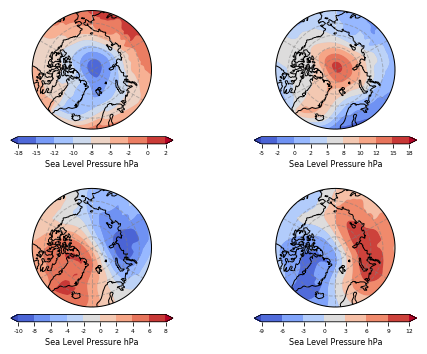

In [16]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_daily_anomaly_DJF_Kmean.png'), dpi=300)
    plt.close(fig)

In [18]:
    print ('======================   check the heat map of K-mean   ======================')
    print ('ERA-Interim')
    print (clust_labels_era)
    print ('mode 1', len(clust_labels_era[clust_labels_era==0])/len(clust_labels_era))
    print ('mode 2', len(clust_labels_era[clust_labels_era==1])/len(clust_labels_era))
    print ('mode 3', len(clust_labels_era[clust_labels_era==2])/len(clust_labels_era))
    print ('mode 4', len(clust_labels_era[clust_labels_era==3])/len(clust_labels_era))
    #print ('mode 5', len(clust_labels_era[clust_labels_era==4])/len(clust_labels_era))
    #print ('mode 6', len(clust_labels_era[clust_labels_era==5])/len(clust_labels_era))
    #print ('mode 7', len(clust_labels_era[clust_labels_era==6])/len(clust_labels_era))
    #print ('mode 8', len(clust_labels_era[clust_labels_era==7])/len(clust_labels_era))

======================   check the heat map of K-mean   ======================
ERA-Interim
[2 2 2 ... 2 2 2]
mode 1 0.21783625730994152
mode 2 0.21695906432748538
mode 3 0.3087719298245614
mode 4 0.2564327485380117


==================   projection of data back to the cluster   ==================
==================   the eigen values are euclidean distance  ==================
================== short distance means close to the pattern  ==================


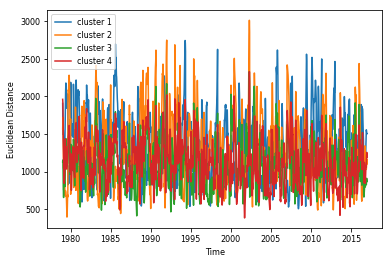

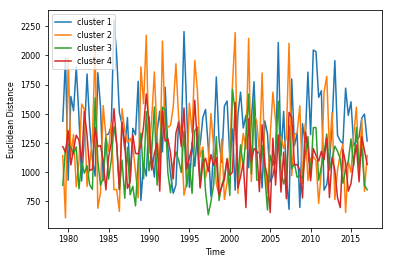

In [19]:
    print ('==================   projection of data back to the cluster   ==================')
    print ('==================   the eigen values are euclidean distance  ==================')
    print ('================== short distance means close to the pattern  ==================')
    SLP_ERAI_Kmean_proj = np.zeros((4,len(clust_labels_era)), dtype=float)
    for i in np.arange(4):
        mode = centers_spatial_era[i,:,:]
        mode_3D = np.repeat(mode[np.newaxis,:,:],len(clust_labels_era),0)
        SLP_ERAI_Kmean_proj[i,:] = np.mean(np.mean(np.abs(mode_3D-SLP_ERAI_daily_DJF_anomalies),2),1)

    index_full = np.arange(1,365*Dim_year+1,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,90*Dim_year+1,1)        
        
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(90,len(year_ERAI)*90+90+1,90*5),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_daily_anomaly_DJF_Kmean_eigen.png'),dpi=300)
    plt.close(fig)
    
    # take monthly mean of the projected SLP series
    SLP_ERAI_Kmean_monthly_proj = np.zeros((4,3*Dim_year),dtype=float)
    for i in np.arange(Dim_year):
        SLP_ERAI_Kmean_monthly_proj[:,i*3] = np.mean(SLP_ERAI_Kmean_proj[:,i*90:i*90+31],1) # jan
        SLP_ERAI_Kmean_monthly_proj[:,i*3+1] = np.mean(SLP_ERAI_Kmean_proj[:,i*90+31:i*90+31+28],1) # feb
        SLP_ERAI_Kmean_monthly_proj[:,i*3+2] = np.mean(SLP_ERAI_Kmean_proj[:,i*90+31+28:i*90+31+28+31],1) # dec
        
    index_full = np.arange(1,445,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,115,1)

    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_monthly_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI)*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_monthly_anomaly_DJF_Kmean_eigen.png'),dpi=300)
    plt.close(fig)

==================   filter the data at large time scale   ==================


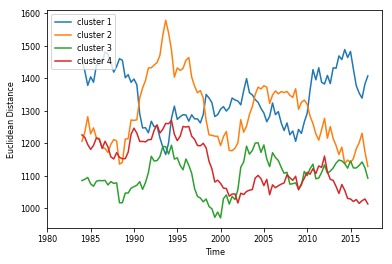

In [20]:
    print ('==================   filter the data at large time scale   ==================')
    _, l = SLP_ERAI_Kmean_monthly_proj.shape
    SLP_ERAI_Kmean_proj_filter = np.zeros((4,l-15+1), dtype=float)
    for i in np.arange(4):
        stat_SLP_ERAI_Kmean = meta.statistics.operator(SLP_ERAI_Kmean_monthly_proj[i,:])
        stat_SLP_ERAI_Kmean.lowpass(window=15, obj='original')
        SLP_ERAI_Kmean_proj_filter[i,:] = stat_SLP_ERAI_Kmean._lowpass

    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season[14:],SLP_ERAI_Kmean_proj_filter[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI[:])*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_monthly_anomaly_DJF_Kmean_eigen_interannual.png'),dpi=300)
    plt.close(fig)

In [21]:
    print ('==================  regression of AMET on the SLP projection  ==================')
    AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                               span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    #stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='anomaly')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_Kmean_proj_filter[i,:],
                                                         stat_AMET_ERAI._lowpass)
        print ('ERA-Interim cluster {}'.format(i+1))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)    

==================  regression of AMET on the SLP projection  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
ERA-Interim cluster 1
regression coefficient (Pa/PW)
0.0003296150689550862
correlation coefficient
0.22845989433149372
t-test
0.022242555464101896
ERA-Interim cluster 2
regression coefficient (Pa/PW)
5.876292966706045e-05
correlation coefficient
0.05273159865706741
t-test
0.6023325996009274
ERA-Interim cluster 3
regression coefficient (Pa/PW)
0.00029689040660176074
correlation coefficient
0.13955452101356328
t-test
0.16611779794191564
ERA-Interim cluster 4
regression coefficient (Pa/PW)
0.0006942154608643818
correlation coefficient
0.46149886726875244
t-test
1.347452881897888e-06


Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [ ]:
    print ('================   K-mean clustering of SLP anomalies in summer  ================')
    # get winter time series
    # ERA-Interim
    SLP_ERAI_season_series = meta.statistics.operator.seasons(SLP_ERAI[:,:lat_ERAI_60+1,:],
                                                              span='JJA', Dim_month=False)    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    # flatten the time series
    t_era, y_era, x_era = stat_SLP_ERAI._anomaly.shape
    stat_SLP_ERAI_anomaly_2D = np.reshape(stat_SLP_ERAI._anomaly,
                                          [t_era, y_era*x_era], order='F')

In [ ]:
    print ('======================   K-mean clustering   ======================')
    kmeans_era = KMeans(n_clusters=4, n_init=50)
    model_era = kmeans_era.fit(stat_SLP_ERAI_anomaly_2D)
    clust_labels_era = model_era.predict(stat_SLP_ERAI_anomaly_2D)
    print("ERA-Interim\n", model_era)

In [ ]:
    print ('===================   check the centers from K-mean clustering   ===================')
    centers_era = model_era.cluster_centers_
    n_era, nn_era = centers_era.shape
    # shape back to the spatial arrangement
    centers_spatial_era = np.reshape(centers_era,[n_era, y_era, x_era], order='F')

In [ ]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields[:lat_ERAI_60+1], standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean.png'), dpi=300)
    plt.close(fig)

In [ ]:
    print ('======================   check the hit map of K-mean   ======================')
    print ('ERA-Interim')
    print (clust_labels_era)
    print ('mode 1', len(clust_labels_era[clust_labels_era==0])/len(clust_labels_era))
    print ('mode 2', len(clust_labels_era[clust_labels_era==1])/len(clust_labels_era))
    print ('mode 3', len(clust_labels_era[clust_labels_era==2])/len(clust_labels_era))
    print ('mode 4', len(clust_labels_era[clust_labels_era==3])/len(clust_labels_era))
    #print ('mode 5', len(clust_labels_era[clust_labels_era==4])/len(clust_labels_era))
    #print ('mode 6', len(clust_labels_era[clust_labels_era==5])/len(clust_labels_era))
    #print ('mode 7', len(clust_labels_era[clust_labels_era==6])/len(clust_labels_era))
    #print ('mode 8', len(clust_labels_era[clust_labels_era==7])/len(clust_labels_era))

In [ ]:
    print ('==================   projection of data back to the cluster   ==================')
    print ('==================   the eigen values are euclidean distance  ==================')
    print ('================== short distance means close to the pattern  ==================')
    SLP_ERAI_Kmean_proj = np.zeros((4,len(clust_labels_era)), dtype=float)
    for i in np.arange(4):
        mode = centers_spatial_era[i,:,:]
        mode_3D = np.repeat(mode[np.newaxis,:,:],len(clust_labels_era),0)
        SLP_ERAI_Kmean_proj[i,:] = np.mean(np.mean(np.abs(mode_3D-stat_SLP_ERAI._anomaly),2),1)

    index_full = np.arange(1,445,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,115,1)        
        
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI)*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean_eigen.png'),dpi=300)
    plt.close(fig)

In [ ]:
    print ('==================   filter the data at large time scale   ==================')
    _, l = SLP_ERAI_Kmean_proj.shape
    SLP_ERAI_Kmean_proj_filter = np.zeros((4,l-15+1), dtype=float)
    for i in np.arange(4):
        stat_SLP_ERAI_Kmean = meta.statistics.operator(SLP_ERAI_Kmean_proj[i,:])
        stat_SLP_ERAI_Kmean.lowpass(window=15, obj='original')
        SLP_ERAI_Kmean_proj_filter[i,:] = stat_SLP_ERAI_Kmean._lowpass

    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season[14:],SLP_ERAI_Kmean_proj_filter[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI[:])*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_JJA_Kmean_eigen_interannual.png'),dpi=300)
    plt.close(fig)

In [ ]:
    print ('==================  pick-up AMET w.r.t. clustering  ==================')
    AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                               span='JJA', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    #stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='anomaly')
    
    print ('==================  regression of AMET on the SLP projection  ==================')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_Kmean_proj_filter[i,:],
                                                         stat_AMET_ERAI._lowpass)
        print ('ERA-Interim cluster {}'.format(i+1))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)    